# Import Libraries

In [ ]:
import tensorflow as tf
from keras import layers
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, Adam # 2 optimizer
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dense, Flatten, GaussianNoise
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
from numpy import mean
from numpy import std
import numpy

In [ ]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the Data

## DataBase Gene expression

In [ ]:
file_list = drive.ListFile({'q': "title='df_Gene_expression.csv' and trashed=false"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    # Lecture du contenu du fichier csv
    content = drive.CreateFile({'id': file_id}).GetContentString()
    # Chargement du contenu csv dans un dataframe
    df_geneE = pd.read_csv(io.StringIO(content), sep =";")
df_geneE.head()

,barcode,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
0,normalized_count_TCGA.CF.A1HS.01A.11R.A13Y.07,0.0,3.5684,5.3975,211.2791,1456.6647,0,49.6115,0.5977,0.0000,...,37.0592,300.6575,1343.0962,84.8775,1457.2624,3380.7531,714.2857,491.3329,9.5637,0.0000
1,normalized_count_TCGA.GD.A3OQ.11A.21R.A220.07,0.0,40.8452,19.1380,128.4473,646.4851,0,253.2622,0.3332,0.0000,...,77.3116,618.1597,1433.2642,13.9961,1333.9587,4102.5145,1777.8341,784.7796,146.6255,0.6665
2,normalized_count_TCGA.ZF.A9R2.01A.11R.A39I.07,0.0,8.7008,11.4256,158.9524,687.9112,0,275.0613,1.0321,0.0000,...,46.9617,561.9920,1369.1137,1.0321,967.1010,5342.2784,1057.9280,757.5797,0.0000,0.0000
3,normalized_count_TCGA.KQ.A41N.01A.11R.A33J.07,0.0,1.1469,2.7191,66.2371,1281.5722,0,695.8763,1.9330,9.0206,...,18.0412,252.5773,1297.0361,305.4124,1706.1856,3100.5155,471.6495,484.5361,9.0206,0.0000
4,normalized_count_TCGA.GC.A6I3.11A.11R.A31N.07,0.0,0.0000,5.3121,95.2855,1551.7928,0,291.5007,0.0000,0.0000,...,32.5365,250.9960,699.2032,25.8964,305.4449,6234.3958,811.4210,281.5405,16.6003,0.0000


In [ ]:
df_geneE.shape

(427, 20532)

In [ ]:
df_geneE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Columns: 20532 entries, barcode to tAKR|389932
dtypes: float64(20241), int64(290), object(1)
memory usage: 66.9+ MB


In [ ]:
df_geneE.describe()

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.0,427.000000,427.000000,427.000000,427.0,...,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,0.026996,10.964525,11.339927,157.678427,1158.179281,0.0,274.540559,0.399187,0.572554,0.0,...,33.028172,304.336629,1060.293981,26.241880,837.301231,5218.024695,985.550465,671.418463,58.026364,0.166658
std,0.150294,11.564773,9.956391,73.114384,433.843481,0.0,237.909563,0.621686,3.673908,0.0,...,17.926149,155.162740,338.484807,53.421476,341.667120,3120.264177,425.092929,333.813756,143.687008,0.980820
min,0.000000,0.000000,0.000000,27.549700,373.337800,0.0,15.926800,0.000000,0.000000,0.0,...,0.612800,6.991900,272.065100,0.000000,198.455700,202.934000,243.902400,197.894700,0.000000,0.000000
25%,0.000000,3.103900,4.813300,111.447050,859.812500,0.0,133.709000,0.000000,0.000000,0.0,...,20.665050,208.418050,834.092750,2.118000,612.282900,3105.511850,697.684000,498.876650,4.409650,0.000000
50%,0.000000,7.273200,8.710900,142.962100,1107.535300,0.0,208.729500,0.000000,0.000000,0.0,...,30.242900,265.139700,1010.533400,6.785900,771.579600,4455.271700,901.438500,630.689200,10.275800,0.000000
75%,0.000000,15.218050,15.076950,186.900200,1348.253450,0.0,328.067550,0.590850,0.000000,0.0,...,43.064400,358.210800,1251.013350,30.054450,993.776500,6381.190450,1191.808000,784.659900,31.973300,0.000000
max,2.110100,85.008700,86.920600,540.545800,4391.826900,0.0,2209.897300,4.589800,43.613700,0.0,...,159.161900,1271.626900,2985.760100,773.533000,2292.213500,20456.713800,3359.870600,4651.404200,1410.816700,18.509000


In [ ]:
df_geneE["barcode"].value_counts()

normalized_count_TCGA.CF.A1HS.01A.11R.A13Y.07    1
normalized_count_TCGA.GC.A3I6.01A.11R.A20F.07    1
normalized_count_TCGA.XF.AAN0.01A.11R.A42T.07    1
normalized_count_TCGA.CF.A9FL.01A.11R.A38B.07    1
normalized_count_TCGA.ZF.AA52.01A.12R.A39I.07    1
                                                ..
normalized_count_TCGA.CU.A0YR.01A.12R.A10U.07    1
normalized_count_TCGA.K4.A3WS.01A.11R.A22U.07    1
normalized_count_TCGA.XF.AAN3.01A.11R.A42T.07    1
normalized_count_TCGA.FD.A3SM.01A.11R.A22U.07    1
normalized_count_TCGA.KQ.A41Q.01A.11R.A33J.07    1
Name: barcode, Length: 427, dtype: int64

## DataBase Methylation

In [ ]:
file_list = drive.ListFile({'q': "title='MethylationReduce.csv' and trashed=false"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    # Lecture du contenu du fichier csv
    content = drive.CreateFile({'id': file_id}).GetContentString()
    # Chargement du contenu csv dans un dataframe
    df_meth = pd.read_csv(io.StringIO(content), sep =";")
df_meth.head()

,Unnamed: 0,barcode,26939,26940,26943,26944,26945,26947,26949,26950,...,485567,485568,485569,485570,485571,485572,485573,485574,485575,485576
0,0,TCGA-DK-AA6S-01A-21D-A392-05,0.559389,0.620501,0.258278,0.842329,0.037122,0.013325,0.357263,0.780032,...,0.678325,0.013738,0.428950,0.012375,0.491295,0.448287,0.968589,0.972004,0.031403,0.695024
1,1,TCGA-DK-A3IK-01A-32D-A21B-05,0.556182,0.169416,0.061357,0.921341,0.031721,0.014455,0.298211,0.794338,...,0.268836,0.011944,0.390979,0.249778,0.968720,0.954569,0.841370,0.486099,0.039529,0.941798
2,2,TCGA-CF-A9FM-01A-11D-A38H-05,0.179499,0.094184,0.039438,0.935348,0.031516,0.010600,0.132181,0.575315,...,0.965567,0.971862,0.397083,0.014208,0.513809,0.949389,0.975109,0.031084,0.027022,0.950084
3,3,TCGA-H4-A2HQ-01A-11D-A17Y-05,0.372331,0.620519,0.115671,0.836389,0.054479,0.018353,0.199210,0.913102,...,0.957051,0.959973,0.464705,0.964441,0.429494,0.026310,0.959222,0.599271,0.538583,0.323739
4,4,TCGA-FD-A3B8-01A-31D-A211-05,0.823523,0.537473,0.111376,0.928734,0.039963,0.016874,0.681077,0.598979,...,0.022895,0.978635,0.433584,0.015292,0.510258,0.028341,0.970803,0.960043,0.505847,0.629377


In [ ]:
# df_meth.describe()

In [ ]:
df_meth["barcode"].value_counts()

TCGA-DK-AA6S-01A-21D-A392-05    1
TCGA-ZF-A9R4-01A-11D-A38H-05    1
TCGA-XF-A8HC-01A-11D-A365-05    1
TCGA-BT-A20J-01A-11D-A14Z-05    1
TCGA-5N-A9KM-01A-11D-A42F-05    1
                               ..
TCGA-FD-A6TB-01A-12D-A33I-05    1
TCGA-CU-A0YO-01A-11D-A10W-05    1
TCGA-BT-A20U-01A-11D-A14Z-05    1
TCGA-4Z-AA7O-01A-31D-A392-05    1
TCGA-ZF-AA4X-01A-11D-A38H-05    1
Name: barcode, Length: 440, dtype: int64

In [ ]:
df_meth.shape

(440, 96002)

## DataBase Protein

In [ ]:
file_list = drive.ListFile({'q': "title='df_prot_expression.csv' and trashed=false"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    # Lecture du contenu du fichier csv
    content = drive.CreateFile({'id': file_id}).GetContentString()
    # Chargement du contenu csv dans un dataframe
    df_prot = pd.read_csv(io.StringIO(content), sep =";")  
df_prot.head()

,barcode,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf-R-V,...,TTF1-R-V,Tuberin-R-E,Tuberin_pT1462-R-V,VEGFR2-R-V,XBP1-G-C,XRCC1-R-E,YAP-R-E,YAP_pS127-R-E,YB-1-R-V,YB-1_pS102-R-V
0,TCGA-2F-A9KO-01A-21-A459-20,0.144162,0.107437,0.112465,0.183165,-0.142706,-0.332475,-0.326587,0.076157,-0.050096,...,-0.062874,-0.359012,0.136182,-0.074833,0.345309,-0.205575,-0.052188,-0.139112,0.111844,-0.065123
1,TCGA-4Z-AA80-01A-21-A458-20,-0.024056,0.004190,-0.259224,-0.103331,0.181644,0.428464,0.205349,0.738733,0.028356,...,0.037279,-0.243887,-0.161180,-0.287152,0.228855,0.166622,-0.181755,-0.090321,-0.333415,0.133465
2,TCGA-FD-A62S-01A-21-A458-20,0.100829,-0.010353,-0.088051,-0.214411,0.119424,-0.013928,0.330129,0.134120,-0.168292,...,0.044071,0.006217,-0.045213,-0.443473,-0.168534,-0.148537,0.078224,0.227924,0.211271,0.355999
3,TCGA-BT-A2LB-01A-21-A209-20,-0.170110,-0.223707,-0.184620,-0.370577,-0.149665,0.027738,0.048750,0.611968,0.019819,...,NaN,0.433135,0.231710,0.271627,-0.288473,0.266724,0.072234,-0.010204,0.092474,0.173585
4,TCGA-FD-A3SN-01A-21-A23Y-20,-0.000668,-0.129307,-0.209477,-0.095544,0.130431,-0.372992,0.126553,-0.418466,0.016428,...,NaN,0.279951,0.259410,0.702777,-0.174990,-0.215259,0.266938,0.958559,-0.029044,-0.087427


In [ ]:
df_prot.shape

(343, 246)


## Patient Data GeneE

In [ ]:
file_list = drive.ListFile({'q': "title='patient_Gene_expression.csv' and trashed=false"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    # Lecture du contenu du fichier csv
    content = drive.CreateFile({'id': file_id}).GetContentString()
    # Chargement du contenu csv dans un dataframe
    dfpatients_geneE = pd.read_csv(io.StringIO(content), sep =";")  
dfpatients_geneE.head()

,Unnamed: 0,barcode,patient,sample,shortLetterCode,definition,sample_submitter_id,sample_type_id,tumor_descriptor,sample_id,...,paper_focal.deletion.in.PTPRD,paper_focal.deletion.in.KDM6A,paper_Neoantigen.load,paper_HLA.mutation,paper_Fusion.in.FGFR3,paper_Fusion.in.PPARG,paper_Fusion.in.PTPN13,paper_Fusion.in.RHOA,paper_Fusion.in.TNFRSF21,paper_Fusion.in.ASIP
0,1,TCGA-CF-A1HS-01A-11R-A13Y-07,TCGA-CF-A1HS,TCGA-CF-A1HS-01A,TP,Primary solid Tumor,TCGA-CF-A1HS-01A,1,Not Reported,0a01e5ba-5549-4027-9e84-1bbb163a8f07,...,.,.,791.0,NaN,no,no,no,no,no,no
1,2,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-GD-A3OQ,TCGA-GD-A3OQ-11A,NT,Solid Tissue Normal,TCGA-GD-A3OQ-11A,11,NaN,fa1b5772-8254-49ba-a385-af8c9ac7fa4f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,TCGA-ZF-A9R2-01A-11R-A39I-07,TCGA-ZF-A9R2,TCGA-ZF-A9R2-01A,TP,Primary solid Tumor,TCGA-ZF-A9R2-01A,1,NaN,d0027b26-44ea-4276-9ad4-e0c47a4564e9,...,Loss,.,400.0,NaN,no,no,no,no,no,no
3,4,TCGA-KQ-A41N-01A-11R-A33J-07,TCGA-KQ-A41N,TCGA-KQ-A41N-01A,TP,Primary solid Tumor,TCGA-KQ-A41N-01A,1,NaN,85d9b3ae-d14a-445f-83bf-e4a9f9b076b8,...,.,.,880.0,NaN,no,no,no,no,no,no
4,5,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-GC-A6I3,TCGA-GC-A6I3-11A,NT,Solid Tissue Normal,TCGA-GC-A6I3-11A,11,NaN,a6bd07c0-2568-42a3-8433-5f2ebfec34b2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfpatients_geneE.shape

(427, 238)

In [ ]:
dfpatients_geneE["primary_diagnosis"].value_counts()

Transitional cell carcinoma              358
Papillary transitional cell carcinoma     66
Squamous cell carcinoma, NOS               1
Papillary adenocarcinoma, NOS              1
Carcinoma, NOS                             1
Name: primary_diagnosis, dtype: int64

## Patient Data methy

In [ ]:
file_list = drive.ListFile({'q': "title='patient_methy.csv' and trashed=false"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    # Lecture du contenu du fichier csv
    content = drive.CreateFile({'id': file_id}).GetContentString()
    # Chargement du contenu csv dans un dataframe
    dfpatients_methy = pd.read_csv(io.StringIO(content), sep =";")  
dfpatients_methy.head()

,Unnamed: 0,barcode,patient,sample,shortLetterCode,definition,sample_submitter_id,sample_type_id,tumor_descriptor,sample_id,...,paper_focal.deletion.in.PTPRD,paper_focal.deletion.in.KDM6A,paper_Neoantigen.load,paper_HLA.mutation,paper_Fusion.in.FGFR3,paper_Fusion.in.PPARG,paper_Fusion.in.PTPN13,paper_Fusion.in.RHOA,paper_Fusion.in.TNFRSF21,paper_Fusion.in.ASIP
0,1,TCGA-DK-AA6S-01A-21D-A392-05,TCGA-DK-AA6S,TCGA-DK-AA6S-01A,TP,Primary solid Tumor,TCGA-DK-AA6S-01A,1,Not Reported,61cf45dc-21ec-40a3-a72b-3edd21895f6b,...,Loss,Del,1543.0,NaN,no,no,no,no,yes,no
1,2,TCGA-DK-A3IK-01A-32D-A21B-05,TCGA-DK-A3IK,TCGA-DK-A3IK-01A,TP,Primary solid Tumor,TCGA-DK-A3IK-01A,1,Not Reported,4ff20c48-29ee-4101-b409-c4573e38cf92,...,Loss,.,642.0,NaN,no,no,no,no,no,no
2,3,TCGA-CF-A9FM-01A-11D-A38H-05,TCGA-CF-A9FM,TCGA-CF-A9FM-01A,TP,Primary solid Tumor,TCGA-CF-A9FM-01A,1,Not Reported,282dcd5c-c35c-4b72-a3ab-571867e304d0,...,.,.,69.0,NaN,no,no,no,no,no,no
3,4,TCGA-H4-A2HQ-01A-11D-A17Y-05,TCGA-H4-A2HQ,TCGA-H4-A2HQ-01A,TP,Primary solid Tumor,TCGA-H4-A2HQ-01A,1,Not Reported,cbedc0db-39fd-4661-9531-cc24d422fac4,...,Del,.,1403.0,NaN,no,no,no,no,no,no
4,5,TCGA-FD-A3B8-01A-31D-A211-05,TCGA-FD-A3B8,TCGA-FD-A3B8-01A,TP,Primary solid Tumor,TCGA-FD-A3B8-01A,1,Not Reported,9a27aa84-d541-4fa3-a798-d7559a5ae70c,...,.,.,148.0,NaN,no,no,no,yes,no,no


# Data Preparation

## Patient geneE

In [ ]:
datapatients_geneE = dfpatients_geneE[["barcode", "primary_diagnosis"]]
datapatients_geneE.head()

,barcode,primary_diagnosis
0,TCGA-CF-A1HS-01A-11R-A13Y-07,"Squamous cell carcinoma, NOS"
1,TCGA-GD-A3OQ-11A-21R-A220-07,Transitional cell carcinoma
2,TCGA-ZF-A9R2-01A-11R-A39I-07,Papillary transitional cell carcinoma
3,TCGA-KQ-A41N-01A-11R-A33J-07,Transitional cell carcinoma
4,TCGA-GC-A6I3-11A-11R-A31N-07,Transitional cell carcinoma


In [ ]:
# datapatients_geneE_sort= datapatients_geneE.sort_values(by = datapatients_geneE.columns[0])
# datapatients_geneE_sort.head()

In [ ]:
datapatients_geneE['barcode'] = datapatients_geneE['barcode'].replace(to_replace ='-', value = '.', regex = True)
datapatients_geneE.head()

<ipython-input-22-242ada0ebcc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datapatients_geneE['barcode'] = datapatients_geneE['barcode'].replace(to_replace ='-', value = '.', regex = True)


,barcode,primary_diagnosis
0,TCGA.CF.A1HS.01A.11R.A13Y.07,"Squamous cell carcinoma, NOS"
1,TCGA.GD.A3OQ.11A.21R.A220.07,Transitional cell carcinoma
2,TCGA.ZF.A9R2.01A.11R.A39I.07,Papillary transitional cell carcinoma
3,TCGA.KQ.A41N.01A.11R.A33J.07,Transitional cell carcinoma
4,TCGA.GC.A6I3.11A.11R.A31N.07,Transitional cell carcinoma


In [ ]:
datapatients_geneE.shape

(427, 2)

## Patient methy

In [ ]:
datapatients_methy = dfpatients_methy[["barcode", "primary_diagnosis"]]
datapatients_methy.head()

,barcode,primary_diagnosis
0,TCGA-DK-AA6S-01A-21D-A392-05,Transitional cell carcinoma
1,TCGA-DK-A3IK-01A-32D-A21B-05,Transitional cell carcinoma
2,TCGA-CF-A9FM-01A-11D-A38H-05,Papillary transitional cell carcinoma
3,TCGA-H4-A2HQ-01A-11D-A17Y-05,Transitional cell carcinoma
4,TCGA-FD-A3B8-01A-31D-A211-05,Transitional cell carcinoma


In [ ]:
datapatients_methy['barcode'] = datapatients_methy['barcode'].replace(to_replace ='-', value = '.', regex = True)
datapatients_methy.head()

<ipython-input-25-3637e789a898>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datapatients_methy['barcode'] = datapatients_methy['barcode'].replace(to_replace ='-', value = '.', regex = True)


,barcode,primary_diagnosis
0,TCGA.DK.AA6S.01A.21D.A392.05,Transitional cell carcinoma
1,TCGA.DK.A3IK.01A.32D.A21B.05,Transitional cell carcinoma
2,TCGA.CF.A9FM.01A.11D.A38H.05,Papillary transitional cell carcinoma
3,TCGA.H4.A2HQ.01A.11D.A17Y.05,Transitional cell carcinoma
4,TCGA.FD.A3B8.01A.31D.A211.05,Transitional cell carcinoma


In [ ]:
datapatients_methy.shape

(440, 2)

In [ ]:
# datapatients_methy['barcode'] = datapatients_methy['barcode'].str.extract('^(.*)\.[A-Za-z0-9]+\.[A-Za-z0-9]+\.[0-9]+.*$')

## Gene expression

In [ ]:
df_geneE = df_geneE.rename(columns={df_geneE.columns[0]: 'barcode'})
df_geneE['barcode'] = df_geneE['barcode'].replace(to_replace ='normalized_count_', value = '', regex = True)
df_geneE.head()

,barcode,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
0,TCGA.CF.A1HS.01A.11R.A13Y.07,0.0,3.5684,5.3975,211.2791,1456.6647,0,49.6115,0.5977,0.0000,...,37.0592,300.6575,1343.0962,84.8775,1457.2624,3380.7531,714.2857,491.3329,9.5637,0.0000
1,TCGA.GD.A3OQ.11A.21R.A220.07,0.0,40.8452,19.1380,128.4473,646.4851,0,253.2622,0.3332,0.0000,...,77.3116,618.1597,1433.2642,13.9961,1333.9587,4102.5145,1777.8341,784.7796,146.6255,0.6665
2,TCGA.ZF.A9R2.01A.11R.A39I.07,0.0,8.7008,11.4256,158.9524,687.9112,0,275.0613,1.0321,0.0000,...,46.9617,561.9920,1369.1137,1.0321,967.1010,5342.2784,1057.9280,757.5797,0.0000,0.0000
3,TCGA.KQ.A41N.01A.11R.A33J.07,0.0,1.1469,2.7191,66.2371,1281.5722,0,695.8763,1.9330,9.0206,...,18.0412,252.5773,1297.0361,305.4124,1706.1856,3100.5155,471.6495,484.5361,9.0206,0.0000
4,TCGA.GC.A6I3.11A.11R.A31N.07,0.0,0.0000,5.3121,95.2855,1551.7928,0,291.5007,0.0000,0.0000,...,32.5365,250.9960,699.2032,25.8964,305.4449,6234.3958,811.4210,281.5405,16.6003,0.0000


In [ ]:
df_geneE.shape

(427, 20532)

In [ ]:
df_geneE_class = pd.merge(df_geneE, datapatients_geneE, on="barcode")
df_geneE_class.head()

,barcode,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,primary_diagnosis
0,TCGA.CF.A1HS.01A.11R.A13Y.07,0.0,3.5684,5.3975,211.2791,1456.6647,0,49.6115,0.5977,0.0000,...,300.6575,1343.0962,84.8775,1457.2624,3380.7531,714.2857,491.3329,9.5637,0.0000,"Squamous cell carcinoma, NOS"
1,TCGA.GD.A3OQ.11A.21R.A220.07,0.0,40.8452,19.1380,128.4473,646.4851,0,253.2622,0.3332,0.0000,...,618.1597,1433.2642,13.9961,1333.9587,4102.5145,1777.8341,784.7796,146.6255,0.6665,Transitional cell carcinoma
2,TCGA.ZF.A9R2.01A.11R.A39I.07,0.0,8.7008,11.4256,158.9524,687.9112,0,275.0613,1.0321,0.0000,...,561.9920,1369.1137,1.0321,967.1010,5342.2784,1057.9280,757.5797,0.0000,0.0000,Papillary transitional cell carcinoma
3,TCGA.KQ.A41N.01A.11R.A33J.07,0.0,1.1469,2.7191,66.2371,1281.5722,0,695.8763,1.9330,9.0206,...,252.5773,1297.0361,305.4124,1706.1856,3100.5155,471.6495,484.5361,9.0206,0.0000,Transitional cell carcinoma
4,TCGA.GC.A6I3.11A.11R.A31N.07,0.0,0.0000,5.3121,95.2855,1551.7928,0,291.5007,0.0000,0.0000,...,250.9960,699.2032,25.8964,305.4449,6234.3958,811.4210,281.5405,16.6003,0.0000,Transitional cell carcinoma


In [ ]:
df_geneE_class.shape

(427, 20533)

In [ ]:
# df_geneE_sort= df_geneE.sort_values(by = df_geneE.columns[0])
# df_geneE_sort.head()

## Methylation

In [ ]:
df_meth['barcode'] = df_meth['barcode'].replace(to_replace ='-', value = '.', regex = True)
df_meth.head()

,Unnamed: 0,barcode,26939,26940,26943,26944,26945,26947,26949,26950,...,485567,485568,485569,485570,485571,485572,485573,485574,485575,485576
0,0,TCGA.DK.AA6S.01A.21D.A392.05,0.559389,0.620501,0.258278,0.842329,0.037122,0.013325,0.357263,0.780032,...,0.678325,0.013738,0.428950,0.012375,0.491295,0.448287,0.968589,0.972004,0.031403,0.695024
1,1,TCGA.DK.A3IK.01A.32D.A21B.05,0.556182,0.169416,0.061357,0.921341,0.031721,0.014455,0.298211,0.794338,...,0.268836,0.011944,0.390979,0.249778,0.968720,0.954569,0.841370,0.486099,0.039529,0.941798
2,2,TCGA.CF.A9FM.01A.11D.A38H.05,0.179499,0.094184,0.039438,0.935348,0.031516,0.010600,0.132181,0.575315,...,0.965567,0.971862,0.397083,0.014208,0.513809,0.949389,0.975109,0.031084,0.027022,0.950084
3,3,TCGA.H4.A2HQ.01A.11D.A17Y.05,0.372331,0.620519,0.115671,0.836389,0.054479,0.018353,0.199210,0.913102,...,0.957051,0.959973,0.464705,0.964441,0.429494,0.026310,0.959222,0.599271,0.538583,0.323739
4,4,TCGA.FD.A3B8.01A.31D.A211.05,0.823523,0.537473,0.111376,0.928734,0.039963,0.016874,0.681077,0.598979,...,0.022895,0.978635,0.433584,0.015292,0.510258,0.028341,0.970803,0.960043,0.505847,0.629377


In [ ]:
df_meth.shape

(440, 96002)

In [ ]:
df_meth_class = pd.merge(df_meth, datapatients_methy, on="barcode")
df_meth_class.head()

,Unnamed: 0,barcode,26939,26940,26943,26944,26945,26947,26949,26950,...,485568,485569,485570,485571,485572,485573,485574,485575,485576,primary_diagnosis
0,0,TCGA.DK.AA6S.01A.21D.A392.05,0.559389,0.620501,0.258278,0.842329,0.037122,0.013325,0.357263,0.780032,...,0.013738,0.428950,0.012375,0.491295,0.448287,0.968589,0.972004,0.031403,0.695024,Transitional cell carcinoma
1,1,TCGA.DK.A3IK.01A.32D.A21B.05,0.556182,0.169416,0.061357,0.921341,0.031721,0.014455,0.298211,0.794338,...,0.011944,0.390979,0.249778,0.968720,0.954569,0.841370,0.486099,0.039529,0.941798,Transitional cell carcinoma
2,2,TCGA.CF.A9FM.01A.11D.A38H.05,0.179499,0.094184,0.039438,0.935348,0.031516,0.010600,0.132181,0.575315,...,0.971862,0.397083,0.014208,0.513809,0.949389,0.975109,0.031084,0.027022,0.950084,Papillary transitional cell carcinoma
3,3,TCGA.H4.A2HQ.01A.11D.A17Y.05,0.372331,0.620519,0.115671,0.836389,0.054479,0.018353,0.199210,0.913102,...,0.959973,0.464705,0.964441,0.429494,0.026310,0.959222,0.599271,0.538583,0.323739,Transitional cell carcinoma
4,4,TCGA.FD.A3B8.01A.31D.A211.05,0.823523,0.537473,0.111376,0.928734,0.039963,0.016874,0.681077,0.598979,...,0.978635,0.433584,0.015292,0.510258,0.028341,0.970803,0.960043,0.505847,0.629377,Transitional cell carcinoma


In [ ]:
df_meth_class.shape

(440, 96003)

## Protein

In [ ]:
df_prot['barcode'] = df_prot['barcode'].replace(to_replace ='-', value = '.', regex = True)
df_prot.head()

,barcode,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf-R-V,...,TTF1-R-V,Tuberin-R-E,Tuberin_pT1462-R-V,VEGFR2-R-V,XBP1-G-C,XRCC1-R-E,YAP-R-E,YAP_pS127-R-E,YB-1-R-V,YB-1_pS102-R-V
0,TCGA.2F.A9KO.01A.21.A459.20,0.144162,0.107437,0.112465,0.183165,-0.142706,-0.332475,-0.326587,0.076157,-0.050096,...,-0.062874,-0.359012,0.136182,-0.074833,0.345309,-0.205575,-0.052188,-0.139112,0.111844,-0.065123
1,TCGA.4Z.AA80.01A.21.A458.20,-0.024056,0.004190,-0.259224,-0.103331,0.181644,0.428464,0.205349,0.738733,0.028356,...,0.037279,-0.243887,-0.161180,-0.287152,0.228855,0.166622,-0.181755,-0.090321,-0.333415,0.133465
2,TCGA.FD.A62S.01A.21.A458.20,0.100829,-0.010353,-0.088051,-0.214411,0.119424,-0.013928,0.330129,0.134120,-0.168292,...,0.044071,0.006217,-0.045213,-0.443473,-0.168534,-0.148537,0.078224,0.227924,0.211271,0.355999
3,TCGA.BT.A2LB.01A.21.A209.20,-0.170110,-0.223707,-0.184620,-0.370577,-0.149665,0.027738,0.048750,0.611968,0.019819,...,NaN,0.433135,0.231710,0.271627,-0.288473,0.266724,0.072234,-0.010204,0.092474,0.173585
4,TCGA.FD.A3SN.01A.21.A23Y.20,-0.000668,-0.129307,-0.209477,-0.095544,0.130431,-0.372992,0.126553,-0.418466,0.016428,...,NaN,0.279951,0.259410,0.702777,-0.174990,-0.215259,0.266938,0.958559,-0.029044,-0.087427


## Normalization Barcode

In [ ]:
# Selection of sample data in barcode
df_meth_class_norm = df_meth_class
df_meth_class_norm['barcode'] = df_meth_class_norm['barcode'].str.extract('^(TCGA.*)\.[A-Za-z0-9]+\.[A-Za-z0-9]+\.[0-9]+.*$')
df_meth_class_norm.head()

,Unnamed: 0,barcode,26939,26940,26943,26944,26945,26947,26949,26950,...,485568,485569,485570,485571,485572,485573,485574,485575,485576,primary_diagnosis
0,0,TCGA.DK.AA6S.01A,0.559389,0.620501,0.258278,0.842329,0.037122,0.013325,0.357263,0.780032,...,0.013738,0.428950,0.012375,0.491295,0.448287,0.968589,0.972004,0.031403,0.695024,Transitional cell carcinoma
1,1,TCGA.DK.A3IK.01A,0.556182,0.169416,0.061357,0.921341,0.031721,0.014455,0.298211,0.794338,...,0.011944,0.390979,0.249778,0.968720,0.954569,0.841370,0.486099,0.039529,0.941798,Transitional cell carcinoma
2,2,TCGA.CF.A9FM.01A,0.179499,0.094184,0.039438,0.935348,0.031516,0.010600,0.132181,0.575315,...,0.971862,0.397083,0.014208,0.513809,0.949389,0.975109,0.031084,0.027022,0.950084,Papillary transitional cell carcinoma
3,3,TCGA.H4.A2HQ.01A,0.372331,0.620519,0.115671,0.836389,0.054479,0.018353,0.199210,0.913102,...,0.959973,0.464705,0.964441,0.429494,0.026310,0.959222,0.599271,0.538583,0.323739,Transitional cell carcinoma
4,4,TCGA.FD.A3B8.01A,0.823523,0.537473,0.111376,0.928734,0.039963,0.016874,0.681077,0.598979,...,0.978635,0.433584,0.015292,0.510258,0.028341,0.970803,0.960043,0.505847,0.629377,Transitional cell carcinoma


In [ ]:
# Remove duplicated row
df_meth_class_norm = df_meth_class_norm.drop_duplicates(subset="barcode")
df_meth_class_norm.shape

(437, 96003)

In [ ]:
# Selection of sample data in barcode
df_geneE_class_norm = df_geneE_class
df_geneE_class_norm['barcode'] = df_geneE_class_norm['barcode'].str.extract('^(TCGA.*)\.[A-Za-z0-9]+\.[A-Za-z0-9]+\.[0-9]+.*$')
df_geneE_class_norm.head()

,barcode,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,primary_diagnosis
0,TCGA.CF.A1HS.01A,0.0,3.5684,5.3975,211.2791,1456.6647,0,49.6115,0.5977,0.0000,...,300.6575,1343.0962,84.8775,1457.2624,3380.7531,714.2857,491.3329,9.5637,0.0000,"Squamous cell carcinoma, NOS"
1,TCGA.GD.A3OQ.11A,0.0,40.8452,19.1380,128.4473,646.4851,0,253.2622,0.3332,0.0000,...,618.1597,1433.2642,13.9961,1333.9587,4102.5145,1777.8341,784.7796,146.6255,0.6665,Transitional cell carcinoma
2,TCGA.ZF.A9R2.01A,0.0,8.7008,11.4256,158.9524,687.9112,0,275.0613,1.0321,0.0000,...,561.9920,1369.1137,1.0321,967.1010,5342.2784,1057.9280,757.5797,0.0000,0.0000,Papillary transitional cell carcinoma
3,TCGA.KQ.A41N.01A,0.0,1.1469,2.7191,66.2371,1281.5722,0,695.8763,1.9330,9.0206,...,252.5773,1297.0361,305.4124,1706.1856,3100.5155,471.6495,484.5361,9.0206,0.0000,Transitional cell carcinoma
4,TCGA.GC.A6I3.11A,0.0,0.0000,5.3121,95.2855,1551.7928,0,291.5007,0.0000,0.0000,...,250.9960,699.2032,25.8964,305.4449,6234.3958,811.4210,281.5405,16.6003,0.0000,Transitional cell carcinoma


In [ ]:
# Remove duplicated row
df_geneE_class_norm = df_geneE_class_norm.drop_duplicates(subset="barcode")
df_geneE_class_norm.shape

(427, 20533)

In [ ]:
# Selection of sample data in barcode
df_prot_norm = df_prot
df_prot_norm['barcode'] = df_prot_norm['barcode'].str.extract('^(TCGA.*)\.[A-Za-z0-9]+\.[A-Za-z0-9]+\.[0-9]+.*$')
df_prot_norm.head()

,barcode,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf-R-V,...,TTF1-R-V,Tuberin-R-E,Tuberin_pT1462-R-V,VEGFR2-R-V,XBP1-G-C,XRCC1-R-E,YAP-R-E,YAP_pS127-R-E,YB-1-R-V,YB-1_pS102-R-V
0,TCGA.2F.A9KO.01A,0.144162,0.107437,0.112465,0.183165,-0.142706,-0.332475,-0.326587,0.076157,-0.050096,...,-0.062874,-0.359012,0.136182,-0.074833,0.345309,-0.205575,-0.052188,-0.139112,0.111844,-0.065123
1,TCGA.4Z.AA80.01A,-0.024056,0.004190,-0.259224,-0.103331,0.181644,0.428464,0.205349,0.738733,0.028356,...,0.037279,-0.243887,-0.161180,-0.287152,0.228855,0.166622,-0.181755,-0.090321,-0.333415,0.133465
2,TCGA.FD.A62S.01A,0.100829,-0.010353,-0.088051,-0.214411,0.119424,-0.013928,0.330129,0.134120,-0.168292,...,0.044071,0.006217,-0.045213,-0.443473,-0.168534,-0.148537,0.078224,0.227924,0.211271,0.355999
3,TCGA.BT.A2LB.01A,-0.170110,-0.223707,-0.184620,-0.370577,-0.149665,0.027738,0.048750,0.611968,0.019819,...,NaN,0.433135,0.231710,0.271627,-0.288473,0.266724,0.072234,-0.010204,0.092474,0.173585
4,TCGA.FD.A3SN.01A,-0.000668,-0.129307,-0.209477,-0.095544,0.130431,-0.372992,0.126553,-0.418466,0.016428,...,NaN,0.279951,0.259410,0.702777,-0.174990,-0.215259,0.266938,0.958559,-0.029044,-0.087427


In [ ]:
# Remove duplicated row
df_prot_norm = df_prot_norm.drop_duplicates(subset="barcode")
df_prot_norm.shape

(343, 246)

## Merge dataSet

In [ ]:
# Merging the two dataset
dfnew=pd.merge(df_geneE_class_norm, df_meth_class_norm, on="barcode")
dfnew=pd.merge(dfnew, df_prot_norm, on="barcode", how="left")
dfnew.shape


(425, 116780)

In [ ]:
# on verifie que les class dans les deux dataframe pour les meme sample sont les mêmes
testres = dfnew['primary_diagnosis_x'].eq(dfnew['primary_diagnosis_x'])
testres.value_counts()

True    425
Name: primary_diagnosis_x, dtype: int64

In [ ]:
dfnew['primary_diagnosis_x'].value_counts()

Transitional cell carcinoma              356
Papillary transitional cell carcinoma     66
Squamous cell carcinoma, NOS               1
Papillary adenocarcinoma, NOS              1
Carcinoma, NOS                             1
Name: primary_diagnosis_x, dtype: int64

In [ ]:
# on retire les class sous-repésentés
to_drop = dfnew[dfnew['primary_diagnosis_x'].isin(['Squamous cell carcinoma, NOS', 'Papillary adenocarcinoma, NOS', 'Carcinoma, NOS'])]

# drop the rows
dfnew = dfnew.drop(to_drop.index)

In [ ]:
dfnew['primary_diagnosis_x'].value_counts()

Transitional cell carcinoma              356
Papillary transitional cell carcinoma     66
Name: primary_diagnosis_x, dtype: int64

In [ ]:
labels = dfnew["primary_diagnosis_x"]
data = dfnew.drop("primary_diagnosis_x", axis =1)
data = data.drop("primary_diagnosis_y", axis =1)
data = data.drop("barcode", axis =1)
data.shape

(422, 116777)

In [ ]:
labels.shape

(422,)

## Anova to reduce dataset

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
# Séparation des données en variables cibles et caractéristiques
X = data
y = labels

# # Supprimer la colonne "barcode" des caractéristiques
# barcode = X["barcode"]
# X = X.drop("barcode", axis=1)

X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda x: x.fillna(x.median()), axis=1)

# Sélection des k meilleures caractéristiques en utilisant ANOVA
k = 40000
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)

# Création d'un tableau qui contiendra les colonnes les plus informatives
important_features = X.columns[selector.get_support()]

# Sélection des caractéristiques les plus informatives
X_important = X[important_features]

# Ajout de la colonne "barcode" au début du tableau final
# X_important.insert(0, 'barcode', barcode)

data = X_important
X_important.head()

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    5     9    16    23  1624  4371  4810  4811  4814  4815  4816  4817
  4818  4819  4822  4831  4834  4835  5288  7661  7662  7663  7664  7665
  8121  9304  9320  9323  9744 10121 10139 10994 11958 12058 12494 12533
 12536 12539 12553 12559 12645 12689 12718 12734 13991 14096 14158 14159
 14160 14161 15138 15140 15141 16566 16568 16569 16571 16572 16574 16579
 16580 16604 16634 16637 16677 16697 16698 16699 16700 16701 16702 16704
 16705 16706 16707 16708 16709 16710 16711 16712 16713 16714 16715 16716
 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726 16727 16728
 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738 16739 16740
 16741 16742 16743 16744 16745 16746 16748 16749 16750 16751 16752 16753
 16754 16756 16757 16758 16759 16760 16761 16762 16763 16764 16765 16766
 16767 16768 16769 16770 16771 16772 16773 16774 16775 16776 16777 16778
 16779 

,?|100130426,?|155060,?|8225,A1BG|1,A2M|2,AACS|65985,AADAT|51166,AARS2|57505,AARS|16,AASDH|132949,...,STAT3_pY705-R-V,Stathmin-R-V,TAZ-R-V,TIGAR-R-V,Transglutaminase-M-V,TTF1-R-V,XRCC1-R-E,YAP-R-E,YB-1-R-V,YB-1_pS102-R-V
1,0.0,253.2622,686.4739,25.0463,37817.0097,506.8577,222.2709,515.5186,2335.6774,410.5514,...,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072
2,0.0,275.0613,1023.8679,7.7409,970.6515,777.7061,387.0468,511.8720,4044.8974,289.5110,...,-0.369563,0.032909,-0.023945,0.181133,-0.268152,0.008597,-0.019129,-0.204656,-0.086345,-0.091418
3,0.0,695.8763,1193.9433,74.0722,3542.9253,590.2062,307.9897,468.3892,3154.6392,247.4227,...,-0.122969,0.032998,-0.060104,0.051055,0.239432,-0.113052,-0.008079,0.045910,-0.063661,0.277920
4,0.0,291.5007,1782.8685,379.7742,46328.8380,620.8499,59.0969,342.6295,2139.4422,177.9548,...,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857
5,0.0,334.3613,1018.9904,27.2034,6345.3368,845.9666,476.5460,516.7862,4555.7539,161.6621,...,0.144769,0.210646,0.359546,0.109924,0.013001,-0.316902,0.149348,1.601137,0.710769,0.303322


In [ ]:
data.shape

(422, 40000)

## Data normalization

In [ ]:
# Replace missing values with a median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

#fit the imputer instance to the data
imputer.fit(data)
#imputer.statistics_
data.median().values

array([0.00000000e+00, 2.09355250e+02, 8.03088400e+02, ...,
       6.71163943e-02, 9.23988552e-02, 6.04368620e-02])

In [ ]:
X = imputer.transform(data)
data_tr = pd.DataFrame(X, columns = data.columns)
data_tr.head()

,?|100130426,?|155060,?|8225,A1BG|1,A2M|2,AACS|65985,AADAT|51166,AARS2|57505,AARS|16,AASDH|132949,...,STAT3_pY705-R-V,Stathmin-R-V,TAZ-R-V,TIGAR-R-V,Transglutaminase-M-V,TTF1-R-V,XRCC1-R-E,YAP-R-E,YB-1-R-V,YB-1_pS102-R-V
0,0.0,253.2622,686.4739,25.0463,37817.0097,506.8577,222.2709,515.5186,2335.6774,410.5514,...,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072,0.622072
1,0.0,275.0613,1023.8679,7.7409,970.6515,777.7061,387.0468,511.8720,4044.8974,289.5110,...,-0.369563,0.032909,-0.023945,0.181133,-0.268152,0.008597,-0.019129,-0.204656,-0.086345,-0.091418
2,0.0,695.8763,1193.9433,74.0722,3542.9253,590.2062,307.9897,468.3892,3154.6392,247.4227,...,-0.122969,0.032998,-0.060104,0.051055,0.239432,-0.113052,-0.008079,0.045910,-0.063661,0.277920
3,0.0,291.5007,1782.8685,379.7742,46328.8380,620.8499,59.0969,342.6295,2139.4422,177.9548,...,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857,0.636857
4,0.0,334.3613,1018.9904,27.2034,6345.3368,845.9666,476.5460,516.7862,4555.7539,161.6621,...,0.144769,0.210646,0.359546,0.109924,0.013001,-0.316902,0.149348,1.601137,0.710769,0.303322


In [ ]:
data_tr.shape

(422, 40000)

In [ ]:
# Data normalization
scaler =  preprocessing.StandardScaler().fit(data_tr)
data_tr = scaler.transform(data_tr)

classes = labels.map(lambda x :0 if x=='Transitional cell carcinoma' else 1)
labels = np_utils.to_categorical(classes) # Add
print (classes)

1      0
2      1
3      0
4      0
5      0
      ..
420    1
421    1
422    0
423    0
424    0
Name: primary_diagnosis_x, Length: 422, dtype: int64


In [ ]:
labels[:10]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Model learning - MLP

In [ ]:
#Data spliting
x_train, x_test, y_train, y_test = train_test_split(data_tr, labels, test_size=0.3, random_state=42) #classes -> labels  
print(y_train.shape)
print(x_train.shape)
print(x_train.shape[1])

classes_train = np_utils.to_categorical(y_train)
classes_test = np_utils.to_categorical(y_test)

(295, 2)
(295, 40000)
40000


## Run MLP

In [ ]:
# Import the early stopping library
from keras.callbacks import EarlyStopping

# Import the dropout library
from keras.layers import Dropout

# Import the library of regulizers
from keras import regularizers

#parameters
learning_rate = 0.01
opt = 'SGD'
hidden1_drop = 0.3
hidden2_drop = 0.3
hidden3_drop = 0.3
hidden4_drop = 0.3
input_drop = 0.2
lambda_l1 = 0.001
lambda_l2 = 0
size_batch= 250
nb_epochs = 100

nb_features = 40000 # nb of neuron

# Create & train the Deep MLP model with 5 hidden layers  
model = Sequential()

# Add the hidden layers and the regulizers
model.add(Dense(2000, input_dim = nb_features, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
# model.add(Activation('relu'))
# model.add(Dropout(input_drop))

model.add(Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
# model.add(Dropout(hidden1_drop))

model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
model.add(Dropout(hidden2_drop))

model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
model.add(Dropout(hidden3_drop))

model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
# model.add(Dropout(hidden4_drop))

model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(lambda_l2))) # 1 -> 2

# Add dropout for each hidden layer

# Compile the model for a multi-class classification problem
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stoping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 30)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = size_batch, epochs=nb_epochs, verbose=1, callbacks=[es])



Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 0.9725 - accuracy: 0.3525 - val_loss: 0.6041 - val_accuracy: 0.8189
Epoch 2/100
2/2 [==============================] - 3s 990ms/step - loss: 0.5590 - accuracy: 0.7898 - val_loss: 0.5466 - val_accuracy: 0.8346
Epoch 3/100
2/2 [==============================] - 3s 1s/step - loss: 0.4861 - accuracy: 0.8407 - val_loss: 0.5196 - val_accuracy: 0.8346
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 0.4696 - accuracy: 0.8576 - val_loss: 0.4742 - val_accuracy: 0.8346
Epoch 5/100
2/2 [==============================] - 3s 1s/step - loss: 0.3856 - accuracy: 0.8881 - val_loss: 0.4304 - val_accuracy: 0.8425
Epoch 6/100
2/2 [==============================] - 3s 1s/step - loss: 0.3428 - accuracy: 0.8780 - val_loss: 0.4101 - val_accuracy: 0.8504
Epoch 7/100
2/2 [==============================] - 3s 1s/step - loss: 0.2989 - accuracy: 0.8983 - val_loss: 0.4153 - val_accuracy: 0.8425
Epoch 8/100
2/2 [==============

In [ ]:
##### Evalute the model
score = model.evaluate(x_test, y_test, batch_size=size_batch, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("Scores on test set: loss=%s accuracy=%s" % tuple(score))
print(score)

1/1 [==============================] - 0s 420ms/step - loss: 0.6339 - accuracy: 0.8504
accuracy: 85.04%
Scores on test set: loss=0.6339316964149475 accuracy=0.8503937125205994
[0.6339316964149475, 0.8503937125205994]


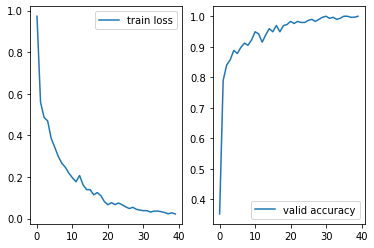

In [ ]:
# plot the train loss and the validation loss
plt.figure(1)

plt.subplot(1,2,1)
out = np.asarray(history.history['loss'])
plt.plot(out, label='train loss')
plt.legend()

plt.subplot(1,2,2)
out = np.asarray(history.history['accuracy'])
plt.plot(out, label='valid accuracy')
plt.legend()

plt.show()

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.5443 - accuracy: 0.7881 - val_loss: 0.4999 - val_accuracy: 0.8136
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.4067 - accuracy: 0.8475 - val_loss: 0.4697 - val_accuracy: 0.8136
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.3601 - accuracy: 0.8517 - val_loss: 0.4719 - val_accuracy: 0.8136
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.3245 - accuracy: 0.8475 - val_loss: 0.4655 - val_accuracy: 0.8136
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.3030 - accuracy: 0.8898 - val_loss: 0.4665 - val_accuracy: 0.8136
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.2746 - accuracy: 0.9153 - val_loss: 0.4818 - val_accuracy: 0.8136
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.2430 - accuracy: 0.9237 - val_loss: 0.4694 - val_accuracy: 0.8305
Epoch 8/100
1/1 [=================

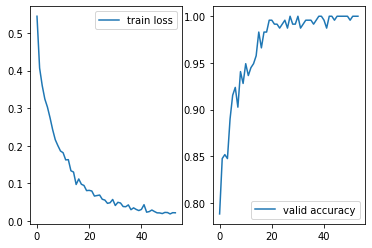

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7521 - accuracy: 0.5593 - val_loss: 0.4069 - val_accuracy: 0.8644
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.4959 - accuracy: 0.7966 - val_loss: 0.3696 - val_accuracy: 0.8814
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.4256 - accuracy: 0.8390 - val_loss: 0.3518 - val_accuracy: 0.8814
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.3803 - accuracy: 0.8517 - val_loss: 0.3295 - val_accuracy: 0.8983
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.3109 - accuracy: 0.8983 - val_loss: 0.3105 - val_accuracy: 0.9153
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.3057 - accuracy: 0.9068 - val_loss: 0.3064 - val_accuracy: 0.9322
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.2622 - accuracy: 0.9068 - val_loss: 0.2890 - val_accuracy: 0.9322
Epoch 8/100
1/1 [=================

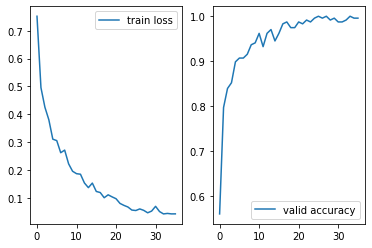

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.9333 - accuracy: 0.3686 - val_loss: 0.6252 - val_accuracy: 0.7288
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.5046 - accuracy: 0.7924 - val_loss: 0.5651 - val_accuracy: 0.8305
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.4479 - accuracy: 0.8390 - val_loss: 0.5567 - val_accuracy: 0.8644
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.3886 - accuracy: 0.8644 - val_loss: 0.5320 - val_accuracy: 0.8644
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.3589 - accuracy: 0.8814 - val_loss: 0.5211 - val_accuracy: 0.8814
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.2976 - accuracy: 0.9068 - val_loss: 0.5177 - val_accuracy: 0.8814
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.2970 - accuracy: 0.8941 - val_loss: 0.5200 - val_accuracy: 0.8814
Epoch 8/100
1/1 [=================

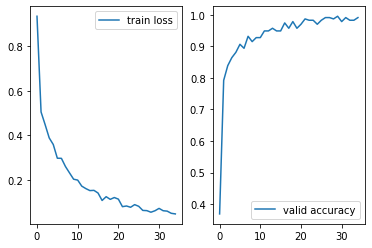

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6026 - accuracy: 0.7076 - val_loss: 0.4066 - val_accuracy: 0.8475
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.4343 - accuracy: 0.8475 - val_loss: 0.3748 - val_accuracy: 0.8644
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.3925 - accuracy: 0.8559 - val_loss: 0.3747 - val_accuracy: 0.8644
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.2898 - accuracy: 0.8983 - val_loss: 0.3585 - val_accuracy: 0.8814
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.3011 - accuracy: 0.8983 - val_loss: 0.3647 - val_accuracy: 0.8644
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.2363 - accuracy: 0.9280 - val_loss: 0.3647 - val_accuracy: 0.8644
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.2336 - accuracy: 0.9364 - val_loss: 0.3684 - val_accuracy: 0.8644
Epoch 8/100
1/1 [=================

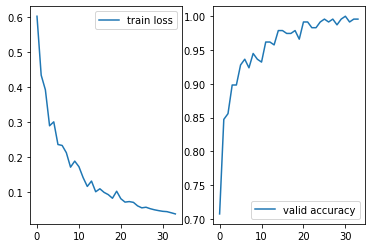

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0175 - accuracy: 0.3305 - val_loss: 0.5148 - val_accuracy: 0.7627
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.5190 - accuracy: 0.7754 - val_loss: 0.4526 - val_accuracy: 0.8136
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.4785 - accuracy: 0.8093 - val_loss: 0.4191 - val_accuracy: 0.8136
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.3514 - accuracy: 0.8644 - val_loss: 0.4040 - val_accuracy: 0.8136
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.3146 - accuracy: 0.9025 - val_loss: 0.3989 - val_accuracy: 0.7966
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.3047 - accuracy: 0.8941 - val_loss: 0.3928 - val_accuracy: 0.8305
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.2119 - accuracy: 0.9534 - val_loss: 0.3861 - val_accuracy: 0.8136
Epoch 8/100
1/1 [=================

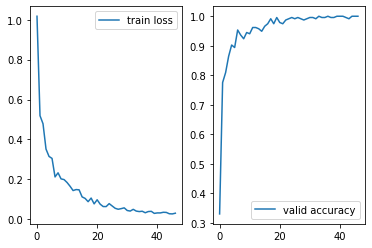

Accuracy: mean=87.797 std=3.107


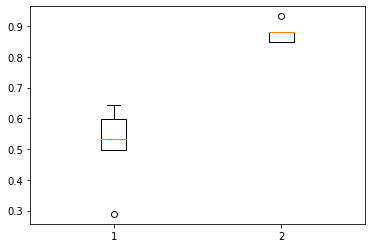

<ipython-input-108-aa7d397c7299>:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-108-aa7d397c7299>:105: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


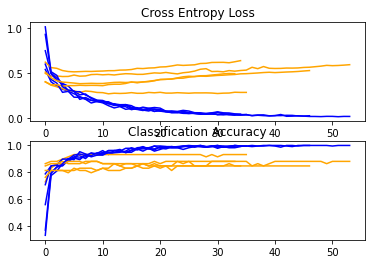

In [ ]:
# Import the early stopping library
from keras.callbacks import EarlyStopping

# Import the dropout library
from keras.layers import Dropout

# Import the library of regulizers
from keras import regularizers

#parameters
learning_rate = 0.01
opt = 'SGD'
hidden1_drop = 0.3
hidden2_drop = 0.3
hidden3_drop = 0.3
hidden4_drop = 0.3
input_drop = 0.2
lambda_l1 = 0.001
lambda_l2 = 0
size_batch= 250
nb_epochs = 100

nb_features = 40000 # nb of neuron

scores, histories = list(), list()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data_tr, labels, test_size=0.3)

for train, test in kfold.split(X_train, y_train):
  # Create & train the Deep MLP model with 5 hidden layers  
  model = Sequential()

  # Add the hidden layers and the regulizers
  model.add(Dense(2000, input_dim = nb_features, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
  # model.add(Activation('relu'))
  # model.add(Dropout(input_drop))

  model.add(Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
  # model.add(Dropout(hidden1_drop))

  model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
  model.add(Dropout(hidden2_drop))

  model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
  model.add(Dropout(hidden3_drop))

  model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)))
  # model.add(Dropout(hidden4_drop))

  model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(lambda_l2))) # 1 -> 2

  # Add dropout for each hidden layer

  # Compile the model for a multi-class classification problem
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # Add early stoping
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 30)

  history = model.fit(X_train[train], y_train[train], validation_data=(X_train[test], y_train[test]), batch_size = size_batch, epochs=nb_epochs, verbose=1, callbacks=[es])

  ##### Evalute the model
  score = model.evaluate(X_train[test], y_train[test], batch_size=size_batch, verbose=1)
  print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  print("Scores on test set: loss=%s accuracy=%s" % tuple(score))
  print(score)

  # plot the train loss and the validation loss
  plt.figure(1)

  plt.subplot(1,2,1)
  out = np.asarray(history.history['loss'])
  plt.plot(out, label='train loss')
  plt.legend()

  plt.subplot(1,2,2)
  out = np.asarray(history.history['accuracy'])
  plt.plot(out, label='valid accuracy')
  plt.legend()

  plt.show()

  scores.append(score)
  histories.append(history)

scores = numpy.array(scores)
#print scores
Acc = scores[:,1]
# print summary
print('Accuracy: mean=%.3f std=%.3f'  % (mean(Acc)*100, std(Acc)*100))
# box and whisker plots of results
pyplot.boxplot(scores)
pyplot.show()

for i in range(len(histories)):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(histories[i].history['loss'], color='blue', label='train')
  pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
  # plot accuracy
  pyplot.subplot(2, 1, 2)
  pyplot.title('Classification Accuracy')
  pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
  pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
pyplot.show()



# Model learning - CNN

## Model Evaluation

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 39998, 45)         180       
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 19999, 45)        0         
 g1D)                                                            
                                                                 
 conv1d_35 (Conv1D)          (None, 19997, 32)         4352      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 9998, 32)         0         
 g1D)                                                            
                                                                 
 dropout_108 (Dropout)       (None, 9998, 32)          0         
                                                                 
 gaussian_noise_15 (Gaussian  (None, 9998, 32)       

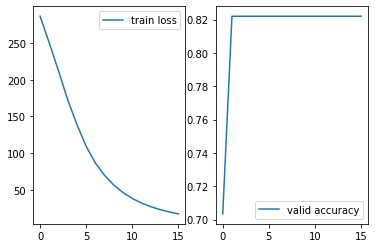

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 39998, 45)         180       
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 19999, 45)        0         
 g1D)                                                            
                                                                 
 conv1d_38 (Conv1D)          (None, 19997, 32)         4352      
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 9998, 32)         0         
 g1D)                                                            
                                                                 
 dropout_109 (Dropout)       (None, 9998, 32)          0         
                                                                 
 gaussian_noise_16 (Gaussian  (None, 9998, 32)       

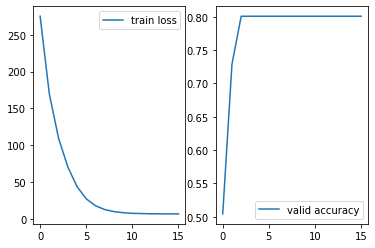

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 39998, 45)         180       
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 19999, 45)        0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 19997, 32)         4352      
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 9998, 32)         0         
 g1D)                                                            
                                                                 
 dropout_110 (Dropout)       (None, 9998, 32)          0         
                                                                 
 gaussian_noise_17 (Gaussian  (None, 9998, 32)       

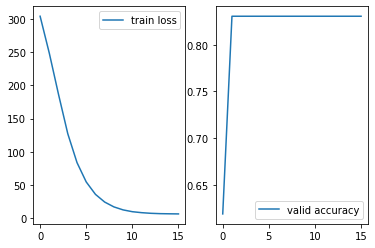

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 39998, 45)         180       
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 19999, 45)        0         
 g1D)                                                            
                                                                 
 conv1d_44 (Conv1D)          (None, 19997, 32)         4352      
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 9998, 32)         0         
 g1D)                                                            
                                                                 
 dropout_111 (Dropout)       (None, 9998, 32)          0         
                                                                 
 gaussian_noise_18 (Gaussian  (None, 9998, 32)       

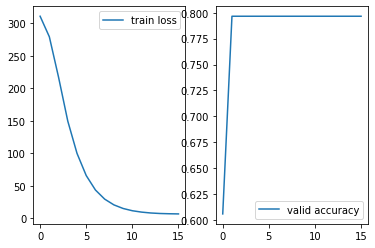

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 39998, 45)         180       
                                                                 
 max_pooling1d_46 (MaxPoolin  (None, 19999, 45)        0         
 g1D)                                                            
                                                                 
 conv1d_47 (Conv1D)          (None, 19997, 32)         4352      
                                                                 
 max_pooling1d_47 (MaxPoolin  (None, 9998, 32)         0         
 g1D)                                                            
                                                                 
 dropout_112 (Dropout)       (None, 9998, 32)          0         
                                                                 
 gaussian_noise_19 (Gaussian  (None, 9998, 32)       

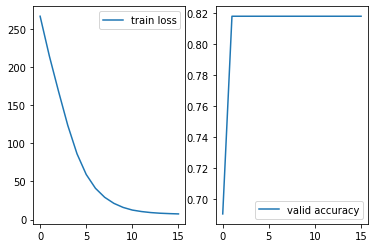

Accuracy: mean=81.356 std=5.141


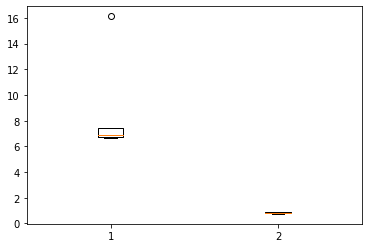

<ipython-input-114-8dd399e0e80c>:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-114-8dd399e0e80c>:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


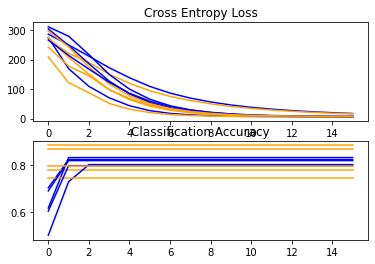

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_tr, labels, test_size=0.3)


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores, histories = list(), list()

# boucle pour chaque tour de la validation croisée
for train, test in kfold.split(X_train, y_train):

  model = Sequential()

  model.add(Conv1D(45, kernel_size=3, activation='relu', padding= 'valid', kernel_initializer='he_uniform', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(32, kernel_size=3, activation='relu', padding= 'valid', kernel_initializer='he_uniform', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(rate=0.3))
  #model.add(BatchNormalization())
  model.add(GaussianNoise(0.01))

  model.add(Conv1D(10, kernel_size=3, activation='relu', padding= 'valid', kernel_initializer='he_uniform', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(0.01)))
  model.add(Dense(2, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  # entraîner le modèle sur les données d'entraînement
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 15)
  history = model.fit(X_train[train], y_train[train], epochs=100, batch_size=32 , validation_data=(X_train[test], y_train[test]) , verbose=1, callbacks=[es])

  # évaluer le modèle sur les données de test
  score = model.evaluate(X_train[test], y_train[test], verbose=1)
  print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

  # plot the train loss and the validation loss
  plt.figure(1)

  plt.subplot(1,2,1)
  out = np.asarray(history.history['loss'])
  plt.plot(out, label='train loss')
  plt.legend()

  plt.subplot(1,2,2)
  out = np.asarray(history.history['accuracy'])
  plt.plot(out, label='valid accuracy')
  plt.legend()

  plt.show()

  scores.append(score)
  histories.append(history)

scores = numpy.array(scores)
#print scores
Acc = scores[:,1]
# print summary
print('Accuracy: mean=%.3f std=%.3f'  % (mean(Acc)*100, std(Acc)*100))
# box and whisker plots of results
pyplot.boxplot(scores)
pyplot.show()

for i in range(len(histories)):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(histories[i].history['loss'], color='blue', label='train')
  pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
  # plot accuracy
  pyplot.subplot(2, 1, 2)
  pyplot.title('Classification Accuracy')
  pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
  pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
pyplot.show()
 
